# Gradient Boosting Training

This notebook trains Gradient Boosting models on:
1. **CIFAR-10** dataset (classification)
2. **London Bike Sharing** dataset (regression)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.models.gradient_boosting import GradientBoosting

DATASET_PATH = "../data/cifar_dataset.pt"
data = torch.load(DATASET_PATH)

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
n_classes = data['n_classes']

print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {n_classes}")


Train set: X=torch.Size([50000, 36]), y=torch.Size([50000])
Test set: X=torch.Size([10000, 36]), y=torch.Size([10000])
Number of features: 36
Number of classes: 10


/tmp/ipykernel_5246/1900915896.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(DATASET_PATH)


In [ ]:
gb_clf = GradientBoosting(
    classification=True,
    n_estimators=10,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    subsample=1.0,
    random_state=42,
    device="cpu",
)

print("Training Gradient Boosting...")
gb_clf.fit(X_train, y_train)
print("Model trained successfully!")


Training Gradient Boosting...
Model trained successfully!


In [ ]:
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)

train_accuracy = (y_train == y_train_pred).float().mean().item()
test_accuracy = (y_test == y_test_pred).float().mean().item()

print("Training Metrics:")
print(f"  Accuracy: {train_accuracy:.4f}")
print("\nTest Metrics:")
print(f"  Accuracy: {test_accuracy:.4f}")


Training Metrics:
  Accuracy: 0.3037

Test Metrics:
  Accuracy: 0.3002


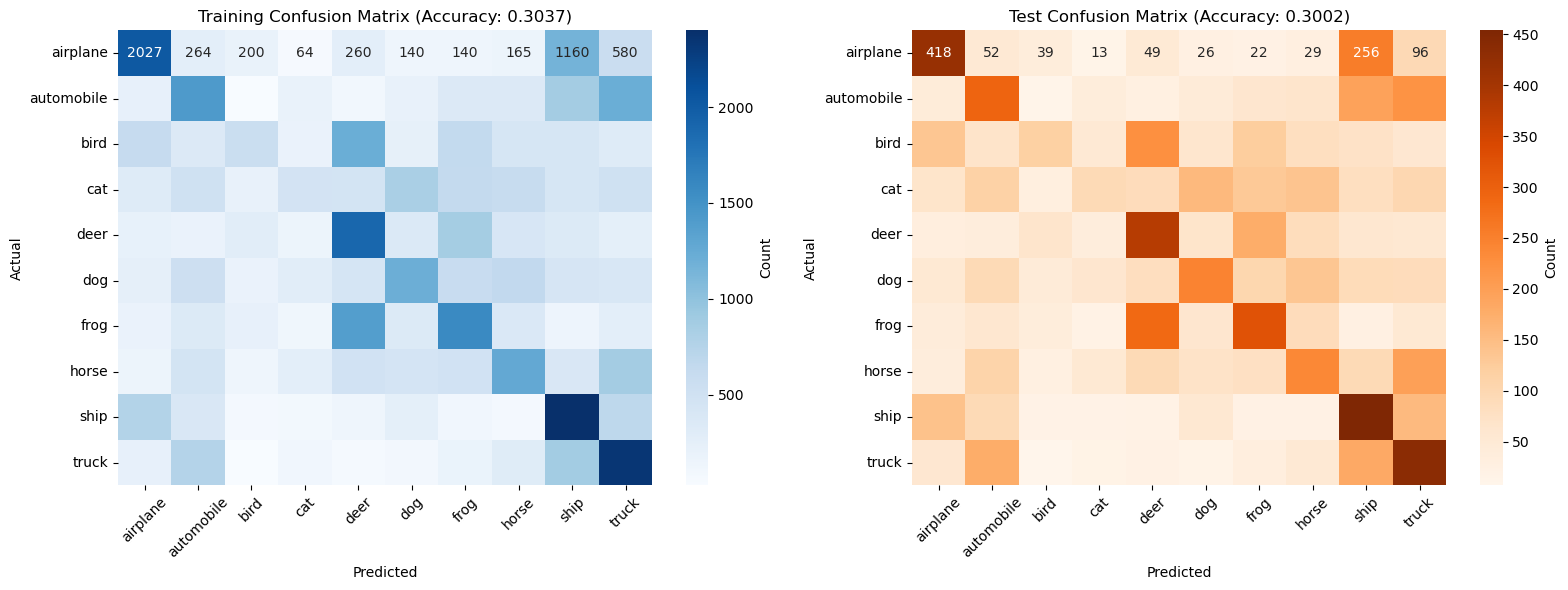

In [ ]:
def confusion_matrix_torch(y_true: torch.Tensor, y_pred: torch.Tensor, n_classes: int):
    """Compute confusion matrix using torch."""
    y_true = y_true.long()
    y_pred = y_pred.long()
    cm = torch.zeros(n_classes, n_classes, dtype=torch.long)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm

def per_class_metrics(y_true: torch.Tensor, y_pred: torch.Tensor, n_classes: int):
    """Compute per-class precision, recall, and f1-score."""
    cm = confusion_matrix_torch(y_true, y_pred, n_classes)
    precision = torch.zeros(n_classes)
    recall = torch.zeros(n_classes)
    f1 = torch.zeros(n_classes)
    
    for i in range(n_classes):
        tp = cm[i, i].float()
        fp = cm[:, i].sum().float() - tp
        fn = cm[i, :].sum().float() - tp
        
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0.0
    
    return precision, recall, f1, cm

import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

cm_train = confusion_matrix_torch(y_train, y_train_pred, n_classes)
cm_test = confusion_matrix_torch(y_test, y_test_pred, n_classes)

cm_train_np = cm_train.numpy()
cm_test_np = cm_test.numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_train_np, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Training Confusion Matrix (Accuracy: {train_accuracy:.4f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(cm_test_np, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Test Confusion Matrix (Accuracy: {test_accuracy:.4f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
def print_classification_report(y_true: torch.Tensor, y_pred: torch.Tensor, 
                                 class_names: list, n_classes: int, dataset_name: str):
    """Print per-class metrics in a readable format."""
    precision, recall, f1, cm = per_class_metrics(y_true, y_pred, n_classes)
    
    support = cm.sum(dim=1).float()
    
    total_support = support.sum().item()
    macro_precision = precision.mean().item()
    macro_recall = recall.mean().item()
    macro_f1 = f1.mean().item()
    accuracy = (y_true == y_pred).float().mean().item()
    
    print(f"\n{dataset_name} - Per-class Metrics:")
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 65)
    for i, name in enumerate(class_names):
        print(f"{name:<15} {precision[i].item():<12.4f} {recall[i].item():<12.4f} "
              f"{f1[i].item():<12.4f} {int(support[i].item()):<10}")
    print("-" * 65)
    print(f"{'accuracy':<15} {'':<12} {'':<12} {accuracy:<12.4f} {int(total_support):<10}")
    print(f"{'macro avg':<15} {macro_precision:<12.4f} {macro_recall:<12.4f} "
          f"{macro_f1:<12.4f} {int(total_support):<10}")
    print(f"{'weighted avg':<15} {(precision * support / total_support).sum().item():<12.4f} "
          f"{(recall * support / total_support).sum().item():<12.4f} "
          f"{(f1 * support / total_support).sum().item():<12.4f} {int(total_support):<10}")

print_classification_report(y_train, y_train_pred, class_names, n_classes, "Training Set")
print_classification_report(y_test, y_test_pred, class_names, n_classes, "Test Set")



Training Set - Per-class Metrics:
Class           Precision    Recall       F1-Score     Support   
-----------------------------------------------------------------
airplane        0.4029       0.4054       0.4041       5000      
automobile      0.2709       0.2836       0.2771       5000      
bird            0.2895       0.1140       0.1636       5000      
cat             0.2374       0.0930       0.1336       5000      
deer            0.2932       0.3790       0.3306       5000      
dog             0.2931       0.2426       0.2655       5000      
frog            0.2815       0.3156       0.2976       5000      
horse           0.2748       0.2556       0.2649       5000      
ship            0.3205       0.4800       0.3843       5000      
truck           0.3135       0.4678       0.3754       5000      
-----------------------------------------------------------------
accuracy                                  0.3037       50000     
macro avg       0.2977       0.3037      

In [ ]:
n_estimators_list = [3, 10, 20]
train_acc_scores = []
test_acc_scores = []

print("Training models with different n_estimators values...")
for n_est in n_estimators_list:
    if n_est == 10:
        gb = gb_clf
    else:
        gb = GradientBoosting(
            classification=True,
            n_estimators=n_est,
            learning_rate=0.1,
            max_depth=3,
            min_samples_split=2,
            subsample=1.0,
            random_state=42,
            device="cpu",
        )
        gb.fit(X_train, y_train)
    
    y_train_pred_curve = gb.predict(X_train)
    y_test_pred_curve = gb.predict(X_test)
    
    train_acc = (y_train == y_train_pred_curve).float().mean().item()
    test_acc = (y_test == y_test_pred_curve).float().mean().item()
    
    train_acc_scores.append(train_acc)
    test_acc_scores.append(test_acc)
    print(f"n_estimators={n_est}: Train={train_acc:.4f}, Test={test_acc:.4f}")

print("Done!")


Training models with different n_estimators values...
n_estimators=3: Train=0.2947, Test=0.2934
n_estimators=10: Train=0.3037, Test=0.3002
n_estimators=20: Train=0.3111, Test=0.3080
Done!


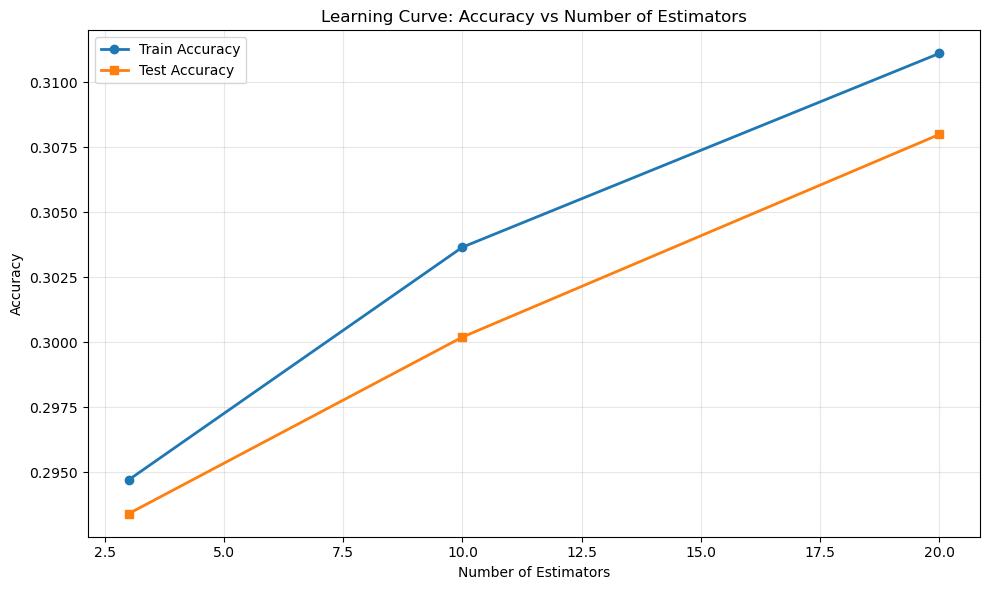


Best n_estimators based on test accuracy: 20
Best test accuracy: 0.3080
Corresponding train accuracy: 0.3111


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(n_estimators_list, train_acc_scores, 'o-', label='Train Accuracy', linewidth=2, markersize=6)
ax.plot(n_estimators_list, test_acc_scores, 's-', label='Test Accuracy', linewidth=2, markersize=6)
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Accuracy')
ax.set_title('Learning Curve: Accuracy vs Number of Estimators')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_test_idx = np.argmax(test_acc_scores)
best_n_est = n_estimators_list[best_test_idx]
print(f"\nBest n_estimators based on test accuracy: {best_n_est}")
print(f"Best test accuracy: {test_acc_scores[best_test_idx]:.4f}")
print(f"Corresponding train accuracy: {train_acc_scores[best_test_idx]:.4f}")


## Part 2: Regression on London Bike Sharing Dataset


In [ ]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.models.gradient_boosting import GradientBoosting
from src.metrics.regression_metrics import RegressionMetrics

DATASET_PATH = "../data/london_bike_dataset.pt"
data = torch.load(DATASET_PATH)

X_reg = data['X']
y_reg = data['y']
feat_names = data['feature_names']

print(f"Loaded dataset: X={X_reg.shape}, y={y_reg.shape}")
print(f"Number of features: {len(feat_names)}")


Loaded dataset: X=torch.Size([17414, 14]), y=torch.Size([17414])
Number of features: 14


/tmp/ipykernel_5246/917494625.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(DATASET_PATH)


In [ ]:
n_samples = X_reg.shape[0]
n_train = int(0.8 * n_samples)
indices = torch.randperm(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

X_train = X_reg[train_indices]
y_train = y_reg[train_indices]
X_test = X_reg[test_indices]
y_test = y_reg[test_indices]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

gb_reg = GradientBoosting(
    classification=False,
    n_estimators=10,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    subsample=1.0,
    random_state=42,
    device="cpu",
)

print("Training Gradient Boosting...")
gb_reg.fit(X_train, y_train)
print("Model trained successfully!")


Training set size: 13931
Test set size: 3483
Number of features: 14
Training Gradient Boosting...
Model trained successfully!


In [ ]:
y_train_pred = gb_reg.predict(X_train)
y_test_pred = gb_reg.predict(X_test)

train_metrics = RegressionMetrics.metrics(y_train, y_train_pred)
test_metrics = RegressionMetrics.metrics(y_test, y_test_pred)

train_mse = train_metrics['mse'].item()
train_mae = train_metrics['mae'].item()
train_r2 = train_metrics['r2'].item()
test_mse = test_metrics['mse'].item()
test_mae = test_metrics['mae'].item()
test_r2 = test_metrics['r2'].item()

print("Training Metrics:")
print(f"  MSE: {train_mse:.2f}")
print(f"  MAE: {train_mae:.2f}")
print(f"  R²:  {train_r2:.4f}")
print("\nTest Metrics:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  R²:  {test_r2:.4f}")


Training Metrics:
  MSE: 447899.78
  MAE: 473.23
  R²:  0.6195

Test Metrics:
  MSE: 446641.44
  MAE: 477.50
  R²:  0.6211


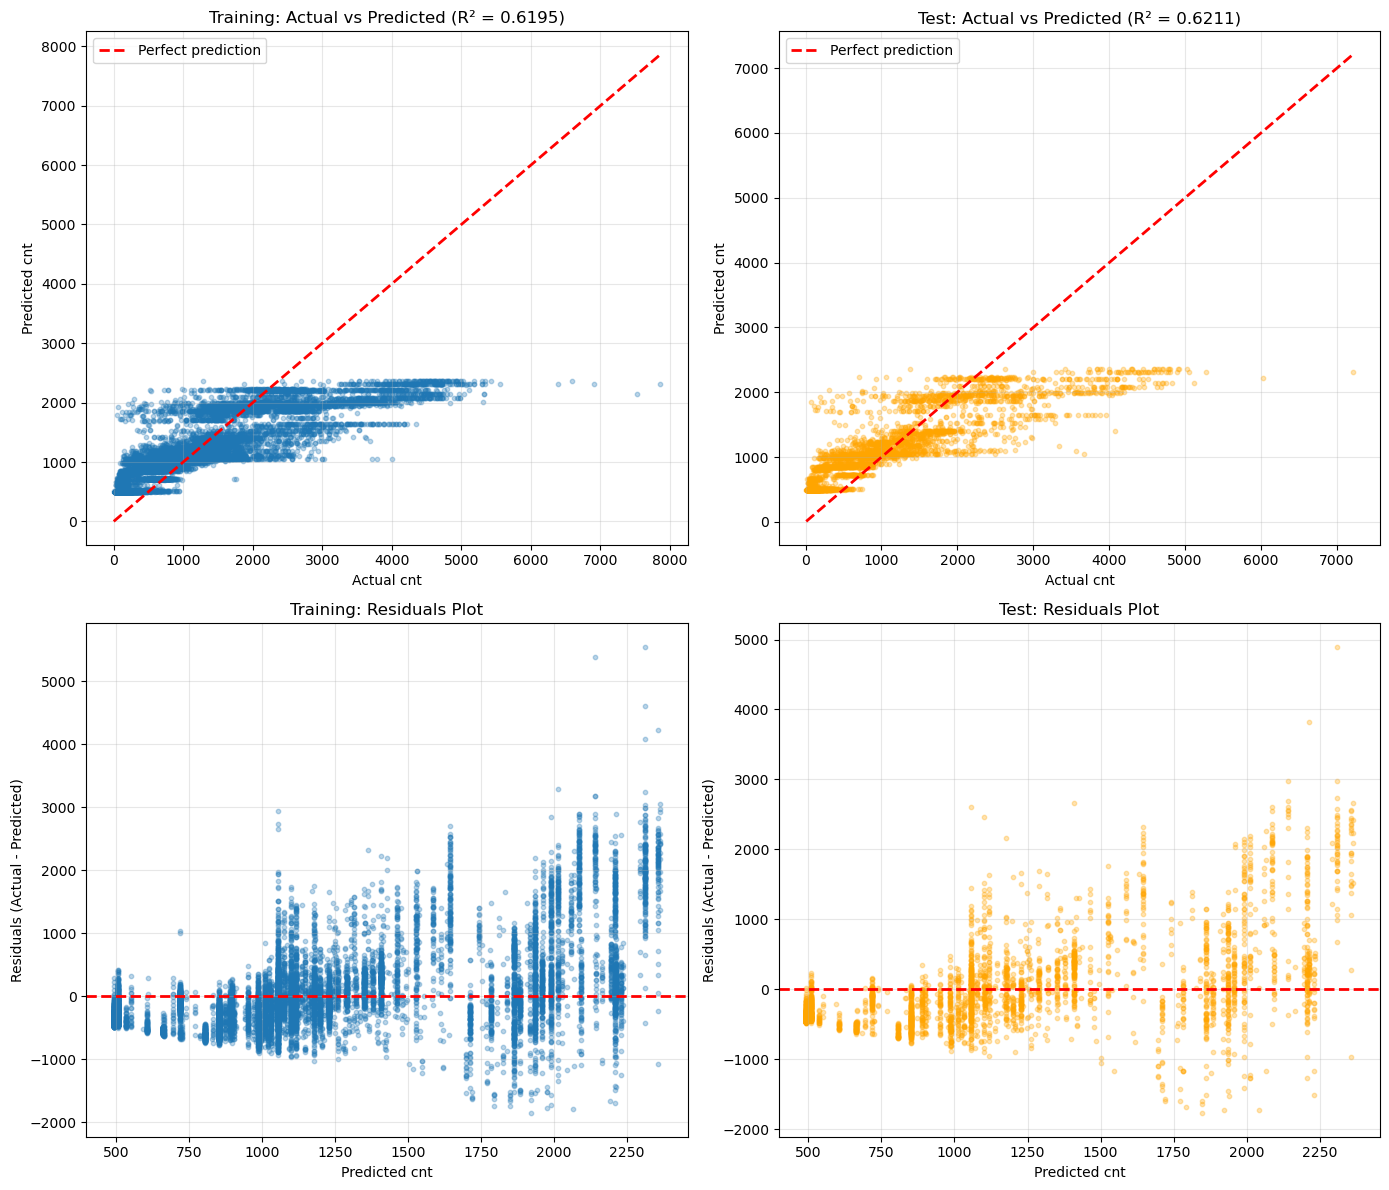

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

y_train_np = y_train.numpy() if isinstance(y_train, torch.Tensor) else y_train
y_test_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test
y_train_pred_np = y_train_pred.numpy() if isinstance(y_train_pred, torch.Tensor) else y_train_pred
y_test_pred_np = y_test_pred.numpy() if isinstance(y_test_pred, torch.Tensor) else y_test_pred

axes[0, 0].scatter(y_train_np, y_train_pred_np, alpha=0.3, s=10)
axes[0, 0].plot([y_train_np.min(), y_train_np.max()], 
                [y_train_np.min(), y_train_np.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Actual cnt')
axes[0, 0].set_ylabel('Predicted cnt')
axes[0, 0].set_title(f'Training: Actual vs Predicted (R² = {train_r2:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_test_np, y_test_pred_np, alpha=0.3, s=10, color='orange')
axes[0, 1].plot([y_test_np.min(), y_test_np.max()], 
                [y_test_np.min(), y_test_np.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 1].set_xlabel('Actual cnt')
axes[0, 1].set_ylabel('Predicted cnt')
axes[0, 1].set_title(f'Test: Actual vs Predicted (R² = {test_r2:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

residuals_train = y_train_np - y_train_pred_np
axes[1, 0].scatter(y_train_pred_np, residuals_train, alpha=0.3, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted cnt')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Training: Residuals Plot')
axes[1, 0].grid(True, alpha=0.3)

residuals_test = y_test_np - y_test_pred_np
axes[1, 1].scatter(y_test_pred_np, residuals_test, alpha=0.3, s=10, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted cnt')
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 1].set_title('Test: Residuals Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
n_estimators_list = [50, 100]
train_mse_scores = []
train_mae_scores = []
train_r2_scores = []
test_mse_scores = []
test_mae_scores = []
test_r2_scores = []

print("Training models with different n_estimators values...")
for n_est in n_estimators_list:
    gb = GradientBoosting(
        classification=False,
        n_estimators=n_est,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        subsample=1.0,
        random_state=42,
        device="cpu",
    )
    gb.fit(X_train, y_train)
    
    y_train_pred_curve = gb.predict(X_train)
    y_test_pred_curve = gb.predict(X_test)
    
    train_metrics_curve = RegressionMetrics.metrics(y_train, y_train_pred_curve)
    test_metrics_curve = RegressionMetrics.metrics(y_test, y_test_pred_curve)
    
    train_mse_scores.append(train_metrics_curve['mse'].item())
    train_mae_scores.append(train_metrics_curve['mae'].item())
    train_r2_scores.append(train_metrics_curve['r2'].item())
    test_mse_scores.append(test_metrics_curve['mse'].item())
    test_mae_scores.append(test_metrics_curve['mae'].item())
    test_r2_scores.append(test_metrics_curve['r2'].item())
    
    print(f"n_estimators={n_est}: Test R²={test_metrics_curve['r2'].item():.4f}")

print("Done!")


Training models with different n_estimators values...
n_estimators=50: Test R²=0.8424
n_estimators=100: Test R²=0.8909
Done!


In [ ]:
n_estimators_list = [200, 500]

print("Training models with different n_estimators values...")
for n_est in n_estimators_list:
    gb = GradientBoosting(
        classification=False,
        n_estimators=n_est,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        subsample=1.0,
        random_state=42,
        device="cpu",
    )
    gb.fit(X_train, y_train)
    
    y_train_pred_curve = gb.predict(X_train)
    y_test_pred_curve = gb.predict(X_test)
    
    train_metrics_curve = RegressionMetrics.metrics(y_train, y_train_pred_curve)
    test_metrics_curve = RegressionMetrics.metrics(y_test, y_test_pred_curve)
    
    train_mse_scores.append(train_metrics_curve['mse'].item())
    train_mae_scores.append(train_metrics_curve['mae'].item())
    train_r2_scores.append(train_metrics_curve['r2'].item())
    test_mse_scores.append(test_metrics_curve['mse'].item())
    test_mae_scores.append(test_metrics_curve['mae'].item())
    test_r2_scores.append(test_metrics_curve['r2'].item())
    
    print(f"n_estimators={n_est}: Test R²={test_metrics_curve['r2'].item():.4f}")

print("Done!")

Training models with different n_estimators values...
n_estimators=200: Test R²=0.9280
n_estimators=500: Test R²=0.9412
Done!


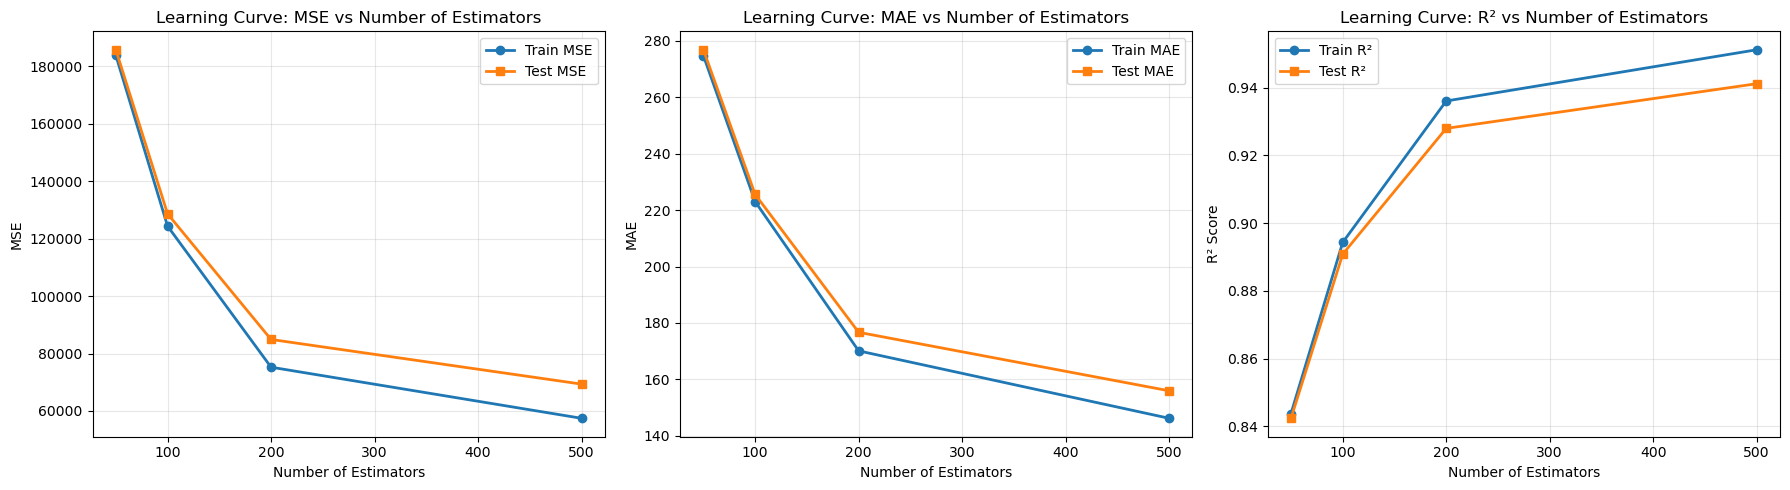


Best n_estimators based on test R²: 500
Best test R²: 0.9412
Best test MSE: 69340.64
Best test MAE: 155.97


In [ ]:
n_estimators_list = [50, 100, 200, 500]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MSE plot
axes[0].plot(n_estimators_list, train_mse_scores, 'o-', label='Train MSE', linewidth=2, markersize=6)
axes[0].plot(n_estimators_list, test_mse_scores, 's-', label='Test MSE', linewidth=2, markersize=6)
axes[0].set_xlabel('Number of Estimators')
axes[0].set_ylabel('MSE')
axes[0].set_title('Learning Curve: MSE vs Number of Estimators')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(n_estimators_list, train_mae_scores, 'o-', label='Train MAE', linewidth=2, markersize=6)
axes[1].plot(n_estimators_list, test_mae_scores, 's-', label='Test MAE', linewidth=2, markersize=6)
axes[1].set_xlabel('Number of Estimators')
axes[1].set_ylabel('MAE')
axes[1].set_title('Learning Curve: MAE vs Number of Estimators')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# R² plot
axes[2].plot(n_estimators_list, train_r2_scores, 'o-', label='Train R²', linewidth=2, markersize=6)
axes[2].plot(n_estimators_list, test_r2_scores, 's-', label='Test R²', linewidth=2, markersize=6)
axes[2].set_xlabel('Number of Estimators')
axes[2].set_ylabel('R² Score')
axes[2].set_title('Learning Curve: R² vs Number of Estimators')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_test_idx = np.argmax(test_r2_scores)
best_n_est = n_estimators_list[best_test_idx]
print(f"\nBest n_estimators based on test R²: {best_n_est}")
print(f"Best test R²: {test_r2_scores[best_test_idx]:.4f}")
print(f"Best test MSE: {test_mse_scores[best_test_idx]:.2f}")
print(f"Best test MAE: {test_mae_scores[best_test_idx]:.2f}")
